# Evaluation metrics

The goal of this lab is to evaluate some classifiers performance according to specific metrics, the most known ones being the accuracy, the recall, the precision and the F1-score.
The classifiers tested will be the Gaussian Naive Bayes, KNN and SVM. The favored feature extraction method, as shown in lab3, will be the PCA. First we will have to extract the number of PCA components which maximizes each classifier's accuracy, and then we evaluate them more deeply with different metrics. Ultimately, we could also discuss about which metric is the most appropriate for our Dataset, even though considering several metrics is also suitable to have an overview on the classifiers' performance.

In [1]:
import os
import cv2
import random
import numpy as np 
import pandas as pd 
import seaborn as sns

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# To plot pretty figures
%matplotlib inline
import matplotlib as mlp
import matplotlib.pyplot as plt

## Data Loading 

This step loads the images contained in the training dataset.

In [2]:
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
train_img = [] #contains the images used for training the model
train_labels = [] #label of each image in x_train 
PATH = 'archive/Training'

for label in labels:
    img_dir = os.path.join(PATH, label)
    for img_file in os.listdir(img_dir):
        img = cv2.imread(f'{img_dir}/{img_file}')
        train_img.append(img)
        train_labels.append(label)
        
new_size = (255, 255)

for i in range(len(train_img)):
    img = train_img[i] 
    train_img[i] = cv2.resize(img, new_size)
    train_img[i] = cv2.cvtColor(train_img[i], cv2.COLOR_RGB2GRAY)/255

train_img = np.stack(train_img)
train_labels = np.stack(train_labels)

print("train_img shape : ", train_img.shape)
print("train_labels shape : ", train_labels.shape)

class_map = {
    'no_tumor': 0,
    'glioma_tumor': 1,
    'pituitary_tumor': 2,
    'meningioma_tumor': 3
}

train_labels = np.array([class_map[label] for label in train_labels])

train_img shape :  (2870, 255, 255)
train_labels shape :  (2870,)


# Dimensionality reduction by PCA implementation

See lab3 for more details

## Reduced dataset creation : 500 samples per class

In [3]:
list_index = []

no_tumor_index = np.where(train_labels == 0)[0][0]
list_index.append(no_tumor_index)

glioma_index = np.where(train_labels == 1)[0][0]
list_index.append(glioma_index)

pituitary_index = np.where(train_labels == 2)[0][0]
list_index.append(pituitary_index)

meningioma_index = np.where(train_labels == 3)[0][0]
list_index.append(meningioma_index)


x = []
y = []
for ind in list_index:
    x.append(train_img[ind : ind+500])
    y.append(train_labels[ind : ind + 500])


flat_x = np.stack(x)
flat_x = flat_x.reshape((flat_x.shape[0]*flat_x.shape[1], 255*255))

flat_y = np.stack(y)
flat_y = flat_y.reshape((flat_y.shape[0]*flat_y.shape[1]))

print("dataset shape : ", flat_x.shape)

dataset shape :  (2000, 65025)


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(flat_x, flat_y, test_size = 0.3, random_state = 42)

In [5]:
from sklearn.preprocessing import StandardScaler #the Standard Scaler : X2 = (X1 - E(X1))/sqrt(Var(X1))
from sklearn.decomposition import PCA


S = StandardScaler()
X_train = S.fit_transform(X_train)
X_test = S.transform(X_test)

In [6]:
pca = PCA(n_components = 0.75)

pca_train = pca.fit_transform(X_train)
pca_test = pca.transform(X_test)

print("dataset final shape : ", pca_train.shape)

dataset final shape :  (1400, 108)


## Inverse PCA transform and 3D Visualization

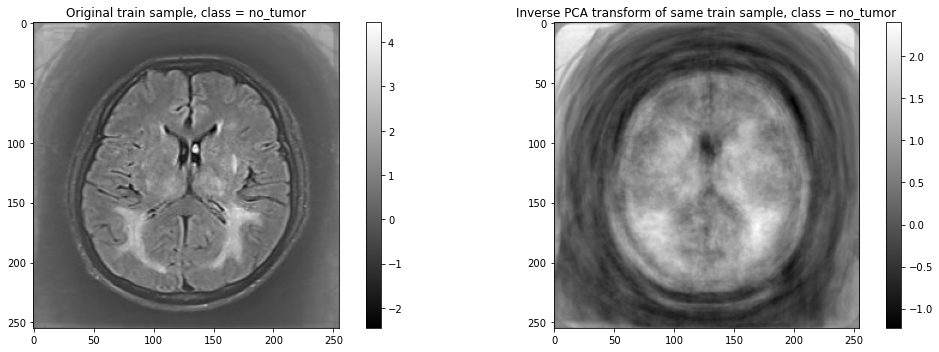

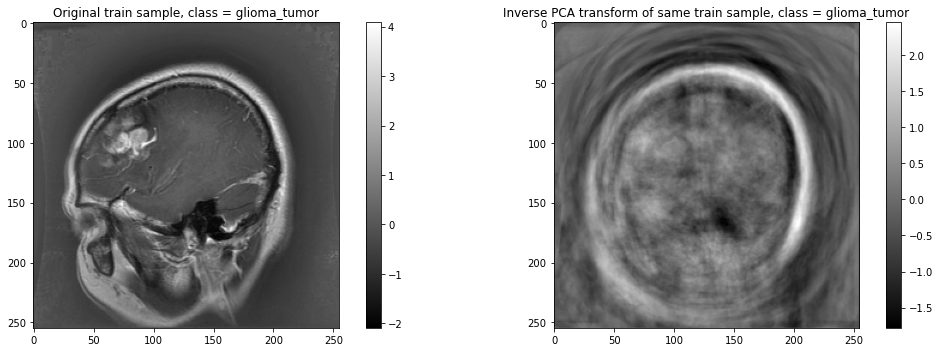

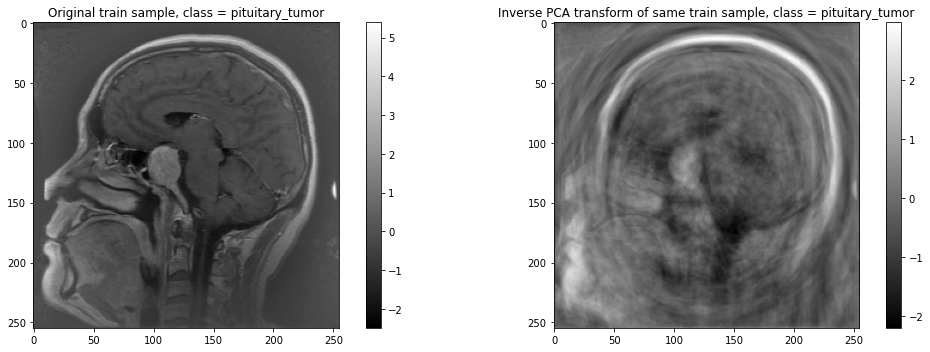

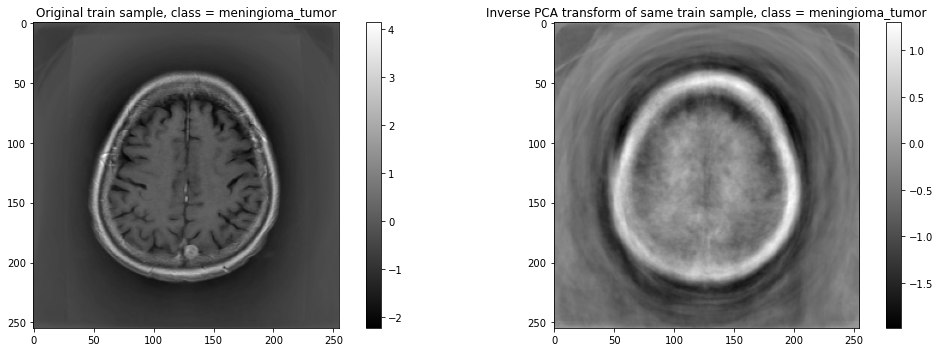

In [7]:
# comparing original samples and their PCA inverser transform
def compare(pca, label = 'no_tumor'):
    #all index of a certain class 
    clas = class_map[label]
    ind = np.where(y_train == clas)[0]
    rand_ind = np.random.choice(ind)

    #PCA inverse transform
    X_inv = pca.inverse_transform(pca_train)

    #original sample
    x_orig = X_train[rand_ind].reshape(255,255)
    #pca inv transform sample
    x_pca = X_inv[rand_ind].reshape(255,255)

    #plot comparison between original and pca inverse transform
    fig, axs = plt.subplots(1,2, figsize = (15, 5))
    im1 = axs[0].imshow(x_orig, cmap = 'gray')
    axs[0].set_title('Original train sample, class = {}'.format(label))
    plt.colorbar(im1, ax = axs[0])

    im2 = axs[1].imshow(x_pca, cmap = 'gray')
    axs[1].set_title('Inverse PCA transform of same train sample, class = {}'.format(label))
    plt.colorbar(im2, ax = axs[1])
    fig.tight_layout()
    plt.show()
    
for key in class_map.keys():
    compare(pca, label = key)

## Classifier evaluation with different metrics

Many metrics are already computed by sklearn modules and methods. Here we propose to code some metrics from scratch, notably the binary confusion matrices, the F1-score, the kappa metric as well as K-fold cross-validation.

In [8]:
# Evaluation Buffers
classifiers = ["NB", "KNN", "SVM"]
pca_comp = []
accL = []
kappa_acc = []
c3_pr = []
c3_recall = []
c3_F1 = [] 

In [9]:
# Data to be exploited

n_comp = np.arange(2, 402, 20)
pca = PCA(n_components =402)
pca_train = pca.fit_transform(X_train)
pca_test = pca.transform(X_test)

### Binary classification

From a confusion matrix, extract a binary one where i is the True Positive class represented by 1. The rest will be represented as 0.

In [10]:
from sklearn.metrics import confusion_matrix, classification_report #to provide confusion matrix with rows = True values and columns = Predicted values

def conf_bin(conf, i):
    row_i = np.sum(conf[i,:]) - conf[i,i]
    col_i = np.sum(conf[:,i]) - conf[i,i]
    rest = np.sum(conf)- row_i - col_i - conf[i,i]
    new_conf = np.array([[conf[i,i], row_i],
                        [col_i, rest]])
    return new_conf

### Kappa metric

The kappa metric measures how much a classifier performs better than chance.

Kappa accuracy can be written as :

$$ Kappa \ accuracy = \frac{D_{classifier} - D_{random}}{D_{ideal} - D_{random}}$$


Where $D_{classifier}$ is the diagonal sum in the confusion matrix of the classifier (e.g. number of good predictions), $D_{random}$ is the diagonal sum in the confusion matrix of the random classifier, and $D_{ideal}$ is the diagonal sum of an ideal predictor e.g. the totality of the samples.
In fact, this metric is relevant when the dataset is unbalanced, for example if it has a minority class. In the case of Fraud detection for example, having 99% accuracy while 1% is actually the proportion which frauds isn't good, whereas the kappa metric would underline this 'bad performance'. If the kappa metric is under 0, the classifier is bad, up to 0.4 it is acceptable but not excellent, and above 0.6 the classifier is considered as very good.
In our case, the dataset is pretty much balanced, unless for the class 'no_tumor' which has twice as less samples than the other classes. Still, we will display the kappa metric for our dataset to have a comparison with the 'global accuracy', but in our case, we will see that it doesn't add much information to the 'global' accuracy.

In [11]:
def random_y(nb_samp, nb_class=4):
    return np.random.randint(nb_class, size =nb_samp)

def kappa_metric(conf_pred, conf_rand):
    return (np.sum(np.diag(conf_pred)) - np.sum(np.diag(conf_rand)))/(np.sum(conf_pred) - np.sum(np.diag(conf_rand)))

### K-fold Cross validation

The idea is to separate the dataset in K folds. At each iteration,  one becomes the test set and the others the training set. The model is then trained K times on the training set and evaluated on the test set. The cross validation returns the accuracy at each iteration and the final accuracy, averaged on all test sets. It gives an accuracy more robust and reliable as variance is given to the test and training sets.

In [12]:
def K_fold_cross_validation(X, y, K=10):
    nb_samp = y.size
    test_size = nb_samp//K
    Test_sets = []
    Test_y = []
    Train_sets = []
    Train_y = []
    for i in range(K):
        Test_sets.append(X[i*test_size:(i+1)*test_size, :])
        Test_y.append(y[i*test_size:(i+1)*test_size])
        if i==0:
            Train_sets.append(X[(i+1)*test_size:,:])
            Train_y.append(y[(i+1)*test_size:])
        elif i==(K-1):
            Train_sets.append(X[:(i)*test_size,:])
            Train_y.append(y[:(i)*test_size])
        else :
            X_train = np.vstack((X[:i*test_size,:], X[(i+1)*test_size:,:]))
            if len(y.shape)<2:
                Y_train = np.hstack((y[:(i)*test_size], y[(i+1)*test_size:]))
            else:
                Y_train = np.vstack((y[:(i)*test_size], y[(i+1)*test_size:]))
            Train_sets.append(X_train)
            Train_y.append(Y_train)
    return Train_sets, Train_y, Test_sets, Test_y

def Kfold_simulation(X, y, model, Kfold=10):
    Train_sets, Train_y, Test_sets, Test_y = K_fold_cross_validation(X, y, K=Kfold)
    acc = []
    kappa_acc = []
    conf_fin = np.zeros((y.max() + 1, y.max() + 1))
    for i in range(Kfold):
        model.fit(Train_sets[i], Train_y[i])
        y_pred = model.predict(Test_sets[i])
        conf = confusion_matrix(Test_y[i], y_pred)
        acci = np.sum((np.diag(conf)))/np.sum(conf)
        
        y_rand = random_y(y_pred.size)
        conf_rand = confusion_matrix(Test_y[i], y_rand)
        kappa = kappa_metric(conf, conf_rand)
        
        acc.append(acci)
        kappa_acc.append(kappa)
        
        print("Test set {}: Accuracy = {} ".format(i, acci), ", Kappa accuracy = {}".format(kappa))
        conf_fin += (1/Kfold)*conf

    avg_acc = np.mean(acc)
    avg_kappa = np.mean(kappa_acc)
    print("Average accuracy by X-validation = ", avg_acc)
    print("Average Kappa accuracy by X-validation = ", avg_kappa)
    return avg_acc, avg_kappa, conf_fin

### Naive Bayes

A Machine Learning algorithm considering data features to be mutually independant and using a gaussian distribution to compute likelihood. Considering Bayes formula, we have :

$P(C_{k}|x) = \frac{P(x|C_{k}) P(C_{k})}{P(x)}$ with $C_{k}$ the k-th class and $x$ an n-feature vector

Using mutual independancy of features, we obtain :


$$P(C_{k}|x)  \propto P(C_{k})\prod \limits_{i=1}^{n} P(x_{i}| C_{k})$$

Therefore the classifier chooses the optimal class $\hat{y}$ by :

$$\hat{y} = \underset{k}{argmax} \Bigg \{P(C_{k})\prod \limits_{i=1}^{n} P(x_{i}| C_{k})\Bigg\} $$

Considering a Gaussian distribution, we have :


$$P(x_{i}=z |C_{k}) = \frac{1}{\sqrt{2 \pi \sigma_{k}^{2}}} \exp{\bigg(-\frac{(z - \mu_{k})^{2}}{2 \sigma_{k}^{2}}\bigg)}$$

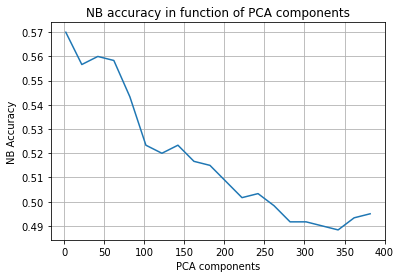

In [13]:
from sklearn.naive_bayes import GaussianNB

acc_NB = []
for n in n_comp:
    NB = GaussianNB()

    NB.fit(pca_train[:,:n], y_train)

    y_pred = NB.predict(pca_test[:,:n])

    cm1 = confusion_matrix(y_test, y_pred)
    acc1 = np.sum(np.diag(cm1))/np.sum(cm1)
    acc_NB.append(acc1)

plt.figure()
plt.plot(n_comp, acc_NB)
plt.grid()
plt.xlabel('PCA components')
plt.ylabel('NB Accuracy')
plt.title('NB accuracy in function of PCA components')
plt.show()

In [14]:
# we choose 20 PCA components as it gives the best accuracy for Naive Bayes

NB = GaussianNB()
NB.fit(pca_train[:,:22], y_train)
y_pred = NB.predict(pca_test[:,:22])
conf_pred = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
rep2 = classification_report(y_test, y_pred, output_dict=True)
print(report)

#binary conf matrix with True Positive = class 0 (True Negative = Else)
cb = conf_bin(conf_pred, i=0)
print('class 0 confusion matrix : \n', cb)

pr_0 = cb[0,0]/np.sum(cb[:,0])
rec_0 = cb[0,0]/np.sum(cb[0,:])
print('\nclass 0 precision : ', pr_0)
print('class 0 recall : ', rec_0)
print('class 0 F1-score : ', 2*(rec_0*pr_0)/(pr_0 +rec_0))

              precision    recall  f1-score   support

           0       0.58      0.42      0.49       120
           1       0.45      0.92      0.61       145
           2       0.77      0.69      0.73       175
           3       0.48      0.18      0.26       160

    accuracy                           0.56       600
   macro avg       0.57      0.55      0.52       600
weighted avg       0.58      0.56      0.53       600

class 0 confusion matrix : 
 [[ 51  69]
 [ 37 443]]

class 0 precision :  0.5795454545454546
class 0 recall :  0.425
class 0 F1-score :  0.49038461538461536


NB :

$$precision = \frac{TP} {TP + FP}$$

$$recall = \frac{TP} {TP + FN}$$

$$F1 = 2 \frac{precision.recall} {precision + recall}$$

While accuracy simply informs of how often the classification is correct; F1 score informs how often a True Positive is indeed classified as True Positive (recall) as well as, if when a class is predicted, it is actually reliable (precision).

Here we notice a global accuracy somewhat superior to the average, however, F1 score for class 0 and class 3 are weak, which means that the classification concerning these classes are unreliable.

kappa accuracy =  0.3813953488372093


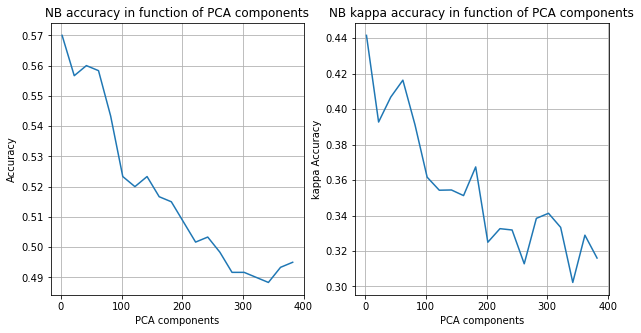

In [15]:
# kappa metric analysis 

y_rand = random_y(nb_samp = y_test.size)
conf_rand = confusion_matrix(y_test, y_rand)
kappa = kappa_metric(conf_pred, conf_rand)
print("kappa accuracy = ", kappa)

kappa_NB = []
for n in n_comp:
    NB = GaussianNB()

    NB.fit(pca_train[:,:n], y_train)

    y_pred = NB.predict(pca_test[:,:n])

    cm1 = confusion_matrix(y_test, y_pred)
    
    y_rand = random_y(nb_samp = y_test.size)
    conf_rand = confusion_matrix(y_test, y_rand)
    kappa = kappa_metric(cm1, conf_rand)
    kappa_NB.append(kappa)

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.plot(n_comp, acc_NB)
plt.grid()
plt.xlabel('PCA components')
plt.ylabel('Accuracy')
plt.title('NB accuracy in function of PCA components')

plt.subplot(1,2,2)
plt.plot(n_comp, kappa_NB)
plt.grid()
plt.xlabel('PCA components')
plt.ylabel('kappa Accuracy')
plt.title('NB kappa accuracy in function of PCA components')
plt.show()

While the global accuracy is ok (59%) the kappa accuracy is rather poor (44%). The NB classifier is certainly doing better than a random one, but the difference isn't that convincing. 

In [16]:
#10 fold cross-validation

NB = GaussianNB()
acc_fin, kappa_fin, conf_fin = Kfold_simulation(np.vstack((pca_train[:,:20], pca_test[:,:20])), np.hstack((y_train, y_test)), NB, Kfold=10)

print("\n Averaged confusion matrix : \n", conf_fin)

Test set 0: Accuracy = 0.65  , Kappa accuracy = 0.5333333333333333
Test set 1: Accuracy = 0.57  , Kappa accuracy = 0.4342105263157895
Test set 2: Accuracy = 0.52  , Kappa accuracy = 0.35135135135135137
Test set 3: Accuracy = 0.64  , Kappa accuracy = 0.5263157894736842
Test set 4: Accuracy = 0.635  , Kappa accuracy = 0.4552238805970149
Test set 5: Accuracy = 0.545  , Kappa accuracy = 0.3591549295774648
Test set 6: Accuracy = 0.605  , Kappa accuracy = 0.47333333333333333
Test set 7: Accuracy = 0.58  , Kappa accuracy = 0.4
Test set 8: Accuracy = 0.505  , Kappa accuracy = 0.36129032258064514
Test set 9: Accuracy = 0.58  , Kappa accuracy = 0.38686131386861317
Average accuracy by X-validation =  0.583
Average Kappa accuracy by X-validation =  0.428107478043123

 Averaged confusion matrix : 
 [[16.   9.4  5.7  8.4]
 [ 0.  44.   3.2  2.8]
 [ 2.4 12.1 45.5  0.5]
 [ 9.1 27.2  2.6 11.1]]


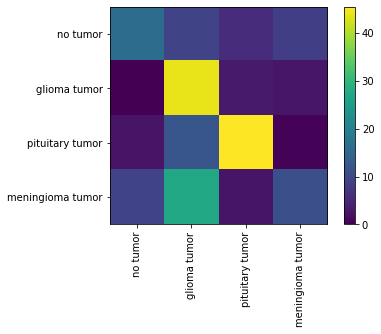

In [17]:
columns = ['no tumor', 'glioma tumor', 'pituitary tumor', 'meningioma tumor']

plt.xticks(range(len(columns)),columns,rotation=90)
plt.yticks(range(len(columns)),columns)
im = plt.imshow(conf_fin, cmap='viridis',interpolation="nearest")
plt.colorbar(im)

plt.show(im)

We have nearly the same results as without cross-validation.

In [18]:
# updating buffer
pca_comp.append(22)
accL.append(acc_fin)
kappa_acc.append(kappa)
conf3 = conf_bin(conf_fin,3)
pr = conf3[0,0]/(np.sum(conf3[:,0]))
rec = conf3[0,0]/(np.sum(conf3[0,:]))
f1 = 2*pr*rec/(pr + rec)
c3_pr.append(pr)
c3_recall.append(rec)
c3_F1.append(f1)

## KNN classifier with different hyperparameters

The KNN model classifies a point by considering the majority class of its k nearest neighbors according to a specific metric. 3 distances are available with sklearn : Euclidian (Minkowski, p = 2), Cosine distance and Cityblock (Manhattan) distance.
We will search for the metric, number of neighbors and pca components that maximize KNN accuracy.

NB : $$d_{cosine}(A,B) = 1 - cos(\hat{AOB}) = 1 - \frac{A.B}{||A||.||B||}$$
$$d_{cityblock}(x,y) = \sum \limits_{i = 1}^{n} |x_{i} - y_{i}|$$

In [19]:
from sklearn.neighbors import KNeighborsClassifier

metrics = ['cityblock', 'cosine', 'minkowski']
neighbors = range(3, 15)
best_acc = 0
best_metric = ''
best_ney = 0
best_n_comp = 0
for metric in metrics :
    for n in n_comp:
        for ney in neighbors:
            knn = KNeighborsClassifier(n_neighbors = ney, metric = metric)
            knn.fit(pca_train[:,:n], y_train)
            y_predict = knn.predict(pca_test[:,:n])
            cm = confusion_matrix(y_test, y_predict)
            accu = np.sum(np.diag(cm))/np.sum(cm)
            if accu>best_acc:
                best_acc = accu
                best_metric = metric
                best_ney = ney
                best_n_comp = n
                
print("Best KNN accuracy = ", best_acc)
print("Reached with {} metric, {} neighbors and {} PCA comp".format(best_metric, best_ney, best_n_comp))

Best KNN accuracy =  0.8566666666666667
Reached with cosine metric, 3 neighbors and 202 PCA comp


In [20]:
# We fit KNN with the best parameters found

knn = KNeighborsClassifier(n_neighbors = best_ney, metric = best_metric)
knn.fit(pca_train[:,:best_n_comp], y_train)
y_pred = knn.predict(pca_test[:,:best_n_comp])

report = classification_report(y_test, y_pred)
print(report)
print("KNN confusion matrix : \n", confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       120
           1       0.84      0.91      0.87       145
           2       0.93      0.95      0.94       175
           3       0.83      0.75      0.79       160

    accuracy                           0.86       600
   macro avg       0.85      0.85      0.85       600
weighted avg       0.86      0.86      0.86       600

KNN confusion matrix : 
 [[ 96  12   5   7]
 [  1 132   0  12]
 [  4   0 166   5]
 [ 19  13   8 120]]


KNN Accuracy is pretty good (80%).
However, F1 score, and more especially the recall for class 3, are weak.
It means that the class 3 is not predicted when it should be predicted : the classifier confuses class 3 with the others, which is underlined by the confusion matrix.

In [21]:
# Testing Kappa accuracy : How much better KNN is from a random classifier ?

y_rand = random_y(nb_samp = y_test.size)
conf_rand = confusion_matrix(y_test, y_rand)
kappa = kappa_metric(confusion_matrix(y_test, y_pred), conf_rand)
print("KNN Kappa accuracy = ", kappa)

KNN Kappa accuracy =  0.8045454545454546


The Kappa accuracy is pretty much satisfactory (73%), which shows that KNN does much better than a random classifier. 

In [22]:
# 10-Fold cross validation 

knn = KNeighborsClassifier(n_neighbors = best_ney, metric = best_metric)
acc_fin, kappa_fin, conf_fin = Kfold_simulation(np.vstack((pca_train[:,:82], pca_test[:,:82])), np.hstack((y_train, y_test)), knn, Kfold=10)

print("\n Averaged confusion matrix : \n", conf_fin)

Test set 0: Accuracy = 0.91  , Kappa accuracy = 0.8807947019867549
Test set 1: Accuracy = 0.89  , Kappa accuracy = 0.8450704225352113
Test set 2: Accuracy = 0.89  , Kappa accuracy = 0.8472222222222222
Test set 3: Accuracy = 0.865  , Kappa accuracy = 0.8269230769230769
Test set 4: Accuracy = 0.9  , Kappa accuracy = 0.8717948717948718
Test set 5: Accuracy = 0.9  , Kappa accuracy = 0.8709677419354839
Test set 6: Accuracy = 0.895  , Kappa accuracy = 0.8571428571428571
Test set 7: Accuracy = 0.88  , Kappa accuracy = 0.85
Test set 8: Accuracy = 0.865  , Kappa accuracy = 0.8223684210526315
Test set 9: Accuracy = 0.885  , Kappa accuracy = 0.847682119205298
Average accuracy by X-validation =  0.8880000000000001
Average Kappa accuracy by X-validation =  0.8519966434798409

 Averaged confusion matrix : 
 [[33.8  1.5  1.5  2.7]
 [ 0.4 45.5  0.7  3.4]
 [ 1.2  0.3 58.7  0.3]
 [ 4.9  3.9  1.6 39.6]]


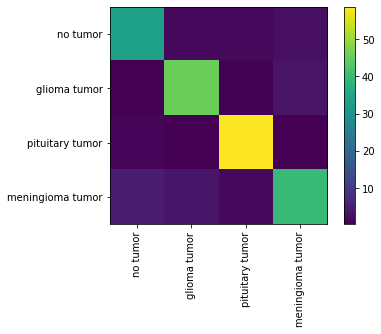

In [23]:
columns = ['no tumor', 'glioma tumor', 'pituitary tumor', 'meningioma tumor']

plt.xticks(range(len(columns)),columns,rotation=90)
plt.yticks(range(len(columns)),columns)
im = plt.imshow(conf_fin, cmap='viridis',interpolation="nearest")
plt.colorbar(im)

plt.show(im)

In [24]:
# updating buffer
pca_comp.append(best_n_comp)
accL.append(acc_fin)
kappa_acc.append(kappa)
conf3 = conf_bin(conf_fin,3)
pr = conf3[0,0]/(np.sum(conf3[:,0]))
rec = conf3[0,0]/(np.sum(conf3[0,:]))
f1 = 2*pr*rec/(pr + rec)
c3_pr.append(pr)
c3_recall.append(rec)
c3_F1.append(f1)

Even better results by cross-validation

### SVM testing

The SVM model computes a hyperplane that maximizes margins between classes using support vectors, which are relevant data points belonging to each class found by solving a quadratic optimization problem. 
The SVM can be approached by first considering a 2-class discrimination problem $(labels \ : 1 \ and \ -1)$.
We consider a dataset of size $p$, with each vector having $n$ features, such that it can be written as :

$\{(x_{1}, l_{1}), (x_{2}, l_{2}), ... ,(x_{p}, l_{p}) \}$ with $x_{i} \in \mathbb{R}^{n}$ and  $l_{i} \in \{-1, 1\}$ for $ i \in \{1,2,...,p\} $.

In a linearly separable problem, the classifying function is given by :

$$ 
h_{w_{0},\ w}(x) = w^{T}x + w_{0}
\ with \ x, w \in \mathbb{R}^{n}$$

Thus $x$ has a label $1$ if $h(x) \geq 0$, and $-1$ otherwise.

As $h(x) = 0$ is the separating hyperplan equation, the goal of SVM Machine Learning is to learn the appropriate weights (components) of the vector $w$ as well as $w_{0}$ such that :

$$l_{k}h_{w_{0},\ w}(x_{k}) \geq 0 \ for \ k \in \{1,2,...,p\}$$

The optimal hyperplan is proven to be the one maximizing margins with support vectors, which are dataset points belonging to each class and are the nearest to the hyperplane. Considering that the smallest distance between samples and the hyperplane is the one of the orthogonal projection on $w$, the weights of the optimal hyperplane are given by : 

$$ (w_{0}, w) = \underset{w_{0}, w}{argmax} \Bigg\{ \frac{1}{||w||} \underset{k}{min}\Bigg(l_{k}h(x_{k})\Bigg)\Bigg\}$$

As on each marge, $h_{w_{0},\ w}(x_{j}) = l_{j} $, we have for $k \in \{1, 2,..., p\}$, the constraint : 

$$l_{k}h_{w_{0},\ w}(x_{k}) \geq 1$$

This gives the final equivalent margin ($\frac{1}{||w||}$) optimization :

$$ min\Bigg\{  \frac{1}{2}||w||^{2} \Bigg\} \ \     s.t.  \ \   l_{k}h_{w_{0},\ w}(x_{k}) \geq 1 \ \ for \ \ k \in \{1,2,...,p\}$$

The hyperplane function can be generalized to non linear problems by changing the linear kernel for another (Gaussian for example), which is the one we choose for the following experimentations. Indeed this kernel shows better results than the linear one and seems to allow a quicker computation of the SVM. 

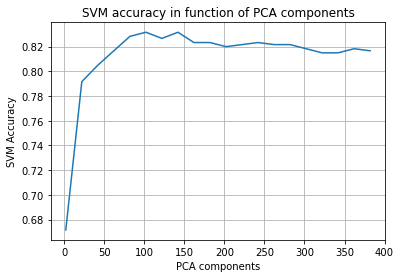

In [25]:
from sklearn import svm

acc_SVM = []
for n in n_comp:
    SVM = svm.SVC(kernel = "rbf", decision_function_shape = 'ovr')
    SVM.fit(pca_train[:,:n], y_train)
    
    y_predict = SVM.predict(pca_test[:,:n])
    
    cm2 = confusion_matrix(y_test, y_predict)
    acc2 = np.sum(np.diag(cm2))/np.sum(cm2)
    
    acc_SVM.append(acc2)

plt.figure()
plt.plot(n_comp, acc_SVM)
plt.grid()
plt.xlabel('PCA components')
plt.ylabel('SVM Accuracy')
plt.title('SVM accuracy in function of PCA components')
plt.show()

In [26]:
SVM = svm.SVC(kernel = "rbf", decision_function_shape = 'ovr')
SVM.fit(pca_train[:,:102], y_train)
    
y_predict = SVM.predict(pca_test[:,:102])
report = classification_report(y_test, y_pred)
print(report)
print("SVM confusion matrix : \n", confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       120
           1       0.84      0.91      0.87       145
           2       0.93      0.95      0.94       175
           3       0.83      0.75      0.79       160

    accuracy                           0.86       600
   macro avg       0.85      0.85      0.85       600
weighted avg       0.86      0.86      0.86       600

SVM confusion matrix : 
 [[ 96  12   5   7]
 [  1 132   0  12]
 [  4   0 166   5]
 [ 19  13   8 120]]


SVM shows like KNN, good results : 81% of global accuracy.
However, like the 2 previous classifiers, the recall for class 3 is not very good, which tends to show that the class 3 is more easily mistaken for others (than the other classes).

SVM Kappa accuracy =  0.8076062639821029


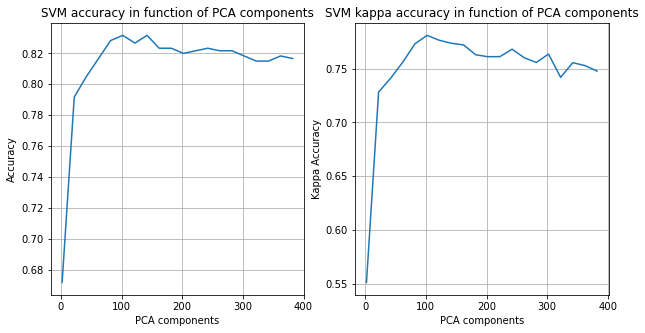

In [27]:
# kappa metric analysis 

conf_pred = confusion_matrix(y_test, y_pred)
y_rand = random_y(nb_samp = y_test.size)
conf_rand = confusion_matrix(y_test, y_rand)
kappa = kappa_metric(conf_pred, conf_rand)
print("SVM Kappa accuracy = ", kappa)

kappa_SVM = []
for n in n_comp:
    SVM = svm.SVC(kernel = "rbf", decision_function_shape = 'ovr')
    SVM.fit(pca_train[:,:n], y_train)
    y_pred = SVM.predict(pca_test[:,:n])
    cm1 = confusion_matrix(y_test, y_pred)
    
    y_rand = random_y(nb_samp = y_test.size)
    conf_rand = confusion_matrix(y_test, y_rand)
    kappa = kappa_metric(cm1, conf_rand)
    kappa_SVM.append(kappa)

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.plot(n_comp, acc_SVM)
plt.grid()
plt.xlabel('PCA components')
plt.ylabel('Accuracy')
plt.title('SVM accuracy in function of PCA components')

plt.subplot(1,2,2)
plt.plot(n_comp, kappa_SVM)
plt.grid()
plt.xlabel('PCA components')
plt.ylabel('Kappa Accuracy')
plt.title('SVM kappa accuracy in function of PCA components')
plt.show()

SVM Kappa accuracy is also good (near 75%) which shows that SVM classifies much better than a random predictor.

In [28]:
# 10-Fold cross validation 

SVM = svm.SVC(kernel = "rbf", decision_function_shape = 'ovr')
acc_fin, kappa_fin, conf_fin = Kfold_simulation(np.vstack((pca_train[:,:82], pca_test[:,:82])), np.hstack((y_train, y_test)), SVM, Kfold=10)

print("\n Averaged confusion matrix : \n", conf_fin)

Test set 0: Accuracy = 0.89  , Kappa accuracy = 0.8533333333333334
Test set 1: Accuracy = 0.86  , Kappa accuracy = 0.8095238095238095
Test set 2: Accuracy = 0.89  , Kappa accuracy = 0.8493150684931506
Test set 3: Accuracy = 0.86  , Kappa accuracy = 0.821656050955414
Test set 4: Accuracy = 0.91  , Kappa accuracy = 0.8867924528301887
Test set 5: Accuracy = 0.855  , Kappa accuracy = 0.8013698630136986
Test set 6: Accuracy = 0.81  , Kappa accuracy = 0.7342657342657343
Test set 7: Accuracy = 0.86  , Kappa accuracy = 0.8095238095238095
Test set 8: Accuracy = 0.845  , Kappa accuracy = 0.7862068965517242
Test set 9: Accuracy = 0.845  , Kappa accuracy = 0.7891156462585034
Average accuracy by X-validation =  0.8625
Average Kappa accuracy by X-validation =  0.8141102664749365

 Averaged confusion matrix : 
 [[32.9  2.7  0.7  3.2]
 [ 0.1 44.   0.5  5.4]
 [ 0.2  0.9 58.8  0.6]
 [ 5.9  4.6  2.7 36.8]]


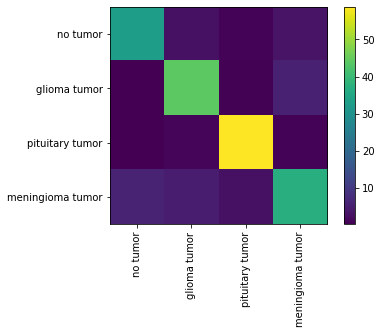

In [29]:
columns = ['no tumor', 'glioma tumor', 'pituitary tumor', 'meningioma tumor']

plt.xticks(range(len(columns)),columns,rotation=90)
plt.yticks(range(len(columns)),columns)
im = plt.imshow(conf_fin, cmap='viridis',interpolation="nearest")
plt.colorbar(im)

plt.show(im)

In [30]:
# updating buffer
pca_comp.append(102)
accL.append(acc_fin)
kappa_acc.append(kappa)
conf3 = conf_bin(conf_fin,3)
pr = conf3[0,0]/(np.sum(conf3[:,0]))
rec = conf3[0,0]/(np.sum(conf3[0,:]))
f1 = 2*pr*rec/(pr + rec)
c3_pr.append(pr)
c3_recall.append(rec)
c3_F1.append(f1)

The cross validation shows similar global and Kappa accuracy than precedently.
The KNN classifier is slightly better in terms of accuracy.

## Global analysis of classifiers

### ROC curve

In this part we will display the ROC (Receiver Operating Characteristic) and AUC (Area Under Curve) of the 3 classifiers (NB, KNN and SVM) in regard to the seemingly most problematic class i.e. class 3 (Meningioma tumor). Therefore, class 3 will be considered as 1, and the rest as 0.
The ROC curve displays the trade-off between True Positive Rate (Recall/Sensitivity) and False Positive Rate (Specificity). Intuitively, we want high TPR but low FPR, therefore, a curve that reaches high values (ideally the top left corner) fast. This goal is equivalent to having high area under the curve (AUC near 1).

Note for the ROC curve (TPR(FPR)) : 
$$TPR = \frac{TP}{TP + FN}$$ 
$$FPR = \frac{FP}{FP + TN}$$ 

TPR or recall measures how often a sample is correctly classified as 1, while FPR measures how often 0 is misclassified as 1.

In [31]:
from sklearn.metrics import roc_curve, roc_auc_score

Y_train = (y_train==3).astype('int')
Y_test = (y_test==3).astype('int')

NB = GaussianNB()
knn = KNeighborsClassifier(n_neighbors = best_ney, metric = best_metric)
SVM = svm.SVC(kernel = "rbf", decision_function_shape = 'ovr', probability = True)

NB.fit(pca_train[:, :20], Y_train)
knn.fit(pca_train[:, :best_n_comp], Y_train)
SVM.fit(pca_train[:, :101], Y_train)

rand_prob = np.zeros(Y_test.size)
nb_prob = NB.predict_proba(pca_test[:,:20])[:,1]
knn_prob = knn.predict_proba(pca_test[:,:best_n_comp])[:,1]
svm_prob = SVM.predict_proba(pca_test[:, :101])[:,1]

In [32]:
rand_auc = roc_auc_score(Y_test, rand_prob) 
nb_auc = roc_auc_score(Y_test, nb_prob) 
nb_auc =  int(nb_auc*100)/100
knn_auc = roc_auc_score(Y_test, knn_prob) 
knn_auc = int(knn_auc*100)/100
svm_auc = roc_auc_score(Y_test, svm_prob) 
svm_auc = int(svm_auc*100)/100

In [33]:
print("Random choice AUROC = ", rand_auc)
print("NB AUROC = ", nb_auc)
print("KNN AUROC = ", knn_auc)
print("SVM AUROC = ", svm_auc)

c3_auc = [nb_auc, knn_auc, svm_auc]

Random choice AUROC =  0.5
NB AUROC =  0.73
KNN AUROC =  0.91
SVM AUROC =  0.91


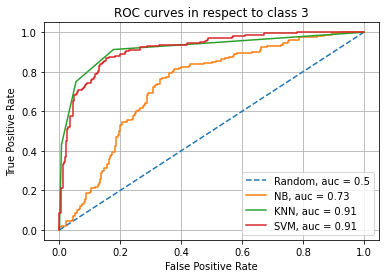

In [34]:
r_fpr, r_tpr, _ = roc_curve(Y_test, rand_prob)
nb_fpr, nb_tpr, _ = roc_curve(Y_test, nb_prob)
knn_fpr,knn_tpr, _ = roc_curve(Y_test, knn_prob)
svm_fpr, svm_tpr, _ = roc_curve(Y_test, svm_prob)

plt.figure()
plt.grid()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(r_fpr, r_tpr, linestyle = '--', label = "Random, auc = {}".format(rand_auc))
plt.plot(nb_fpr, nb_tpr, label = "NB, auc = {}".format(nb_auc))
plt.plot(knn_fpr, knn_tpr, label = "KNN, auc = {}".format(knn_auc))
plt.plot(svm_fpr, svm_tpr, label = "SVM, auc = {}".format(svm_auc))
plt.legend()
plt.title("ROC curves in respect to class 3")
plt.show()

A random classifier is represented by a perfect line, it must be the worst case for a classifier e.g. no classifier should have a curve that evolves below this curve.
NB curve increases slowly, which explains a relatively low AUC (0.72).
KNN and SVM seem to display a similar ROC curve before $FPR = 0.2$, with KNN being sligthly higher than SVM. But past $FPR = 0.2$, SVM curve increases faster.
Ultimately, KNN and SVM have similar AUC, around 0.85, but SVM is a little superior ($AUC = 0.86$). 
Therefore the classifier which has the best TPR-FPR trade-off is the SVM.

### Resume of the classifiers evaluation

In [35]:
data = {'Classifiers':  classifiers,
        'PCA components': pca_comp,
        'Accuracy' : accL,
        'Kappa ': kappa_acc,
        'C3 Precision': c3_pr,
        'C3 Recall' : c3_recall,
        'C3 F1 Score' : c3_F1,
        'C3 AUC' : c3_auc
        }

resume = pd.DataFrame(data)

print(resume)

  Classifiers  PCA components  Accuracy    Kappa   C3 Precision  C3 Recall  \
0          NB              22    0.5830  0.316027      0.486842      0.222   
1         KNN             202    0.8880  0.804545      0.860870      0.792   
2         SVM             102    0.8625  0.747706      0.800000      0.736   

   C3 F1 Score  C3 AUC  
0     0.304945    0.73  
1     0.825000    0.91  
2     0.766667    0.91  


KNN and SVM are definitely the best classifiers among the 3 and are rather similar in terms of evaluation metrics. KNN is slightly more accurate than SVM, but SVM is less likely to misclassify a class for a class 3. The choice between the 2 classifiers could depend on whether we want to classify correctly more samples or minimize C3 misclassification rate.

Moreover, we've seen that the three classifiers and especially KNN and SVM (as NB isn't optimal) show a recall somewhat weaker for class 3, and accordin to the confusion matrices, the 'meningioma tumor' is sometimes misclassified as 'no_tumor'.
So here, we propose to display different images of 'meningioma tumor' and 'no tumor' samples (after PCA inverse transform) to check if there is some similarities to the naked eye.

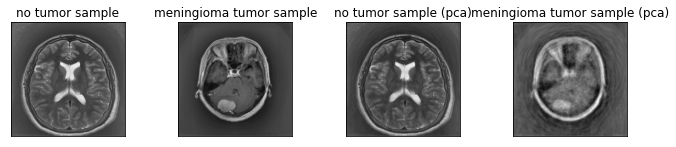

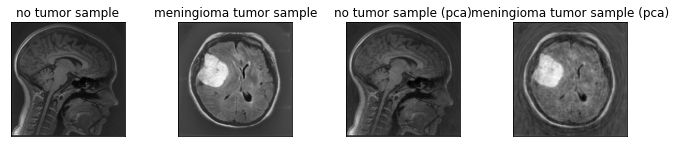

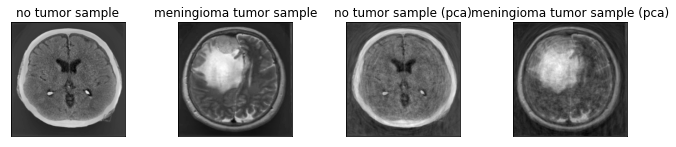

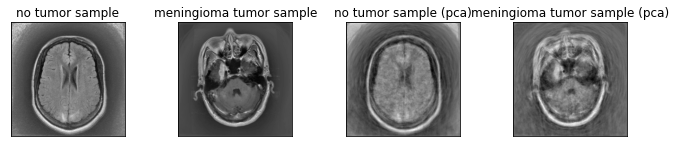

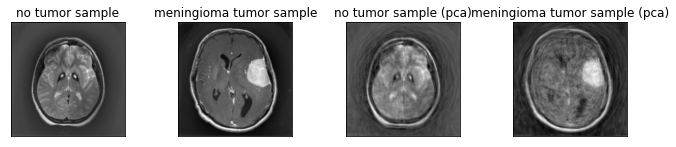

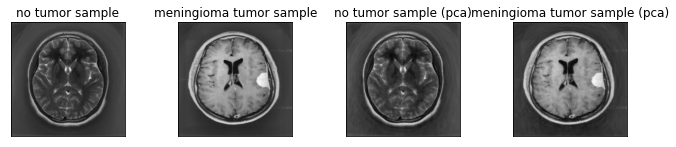

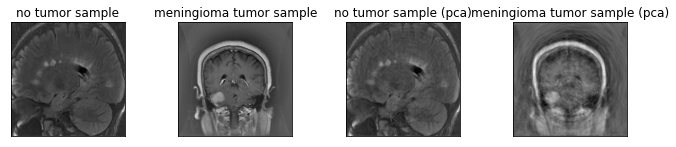

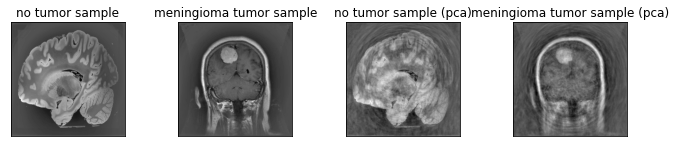

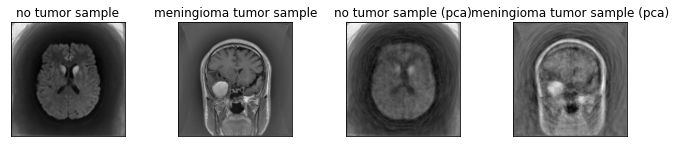

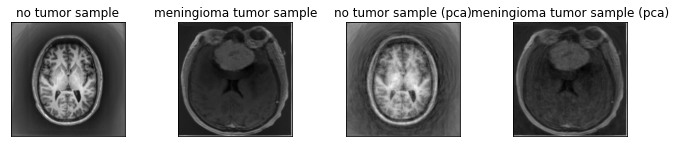

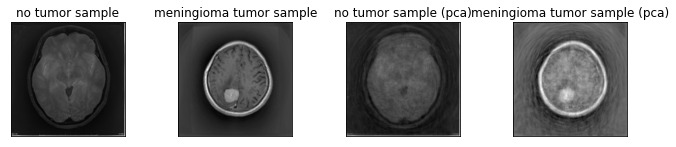

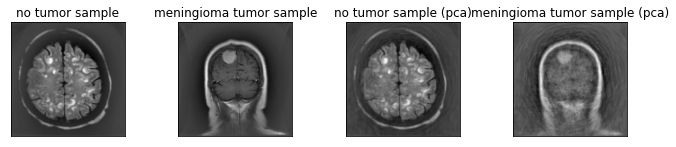

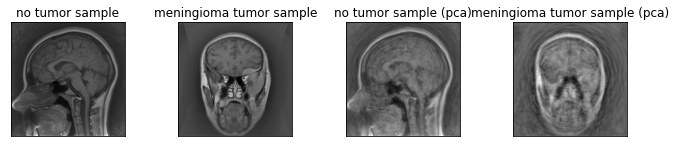

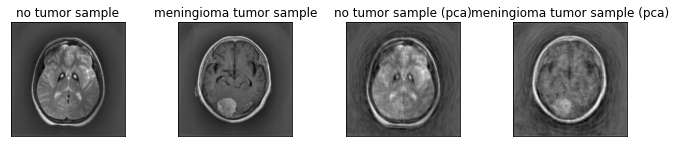

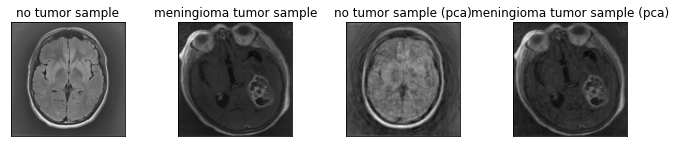

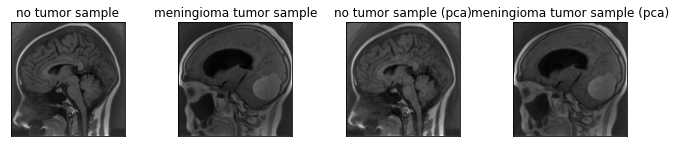

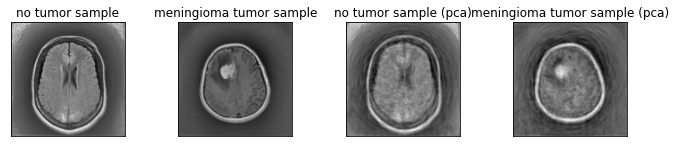

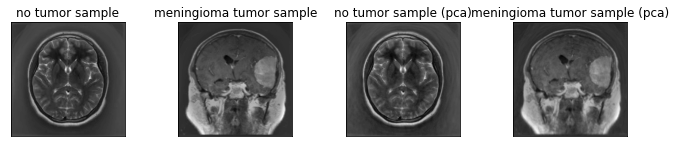

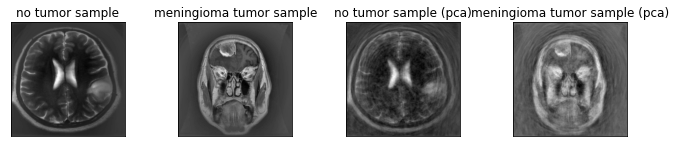

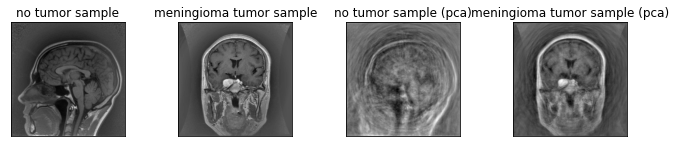

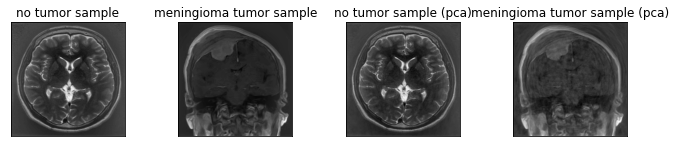

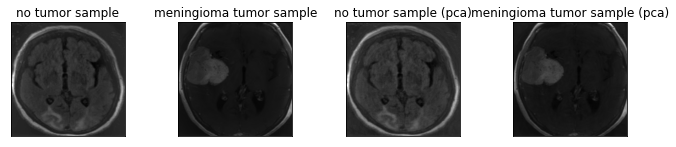

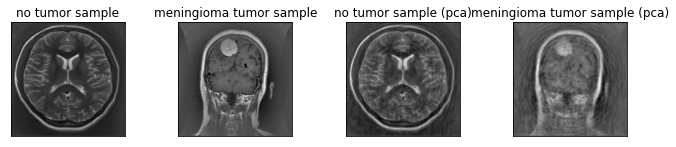

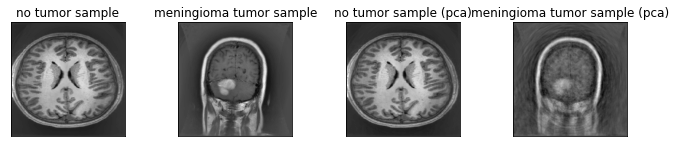

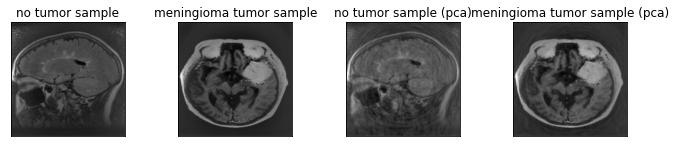

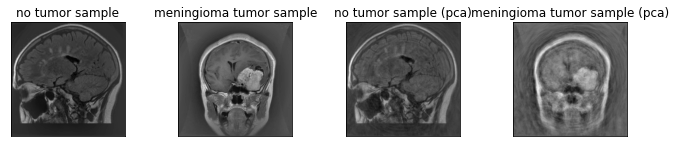

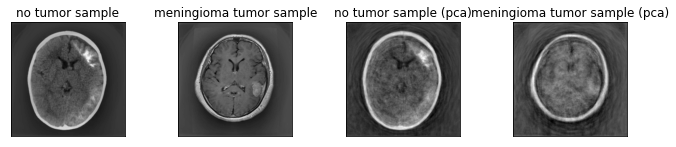

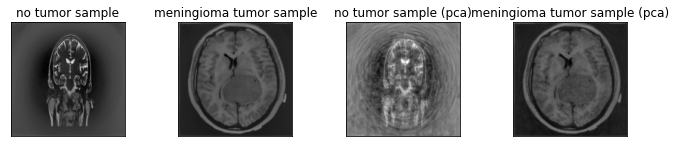

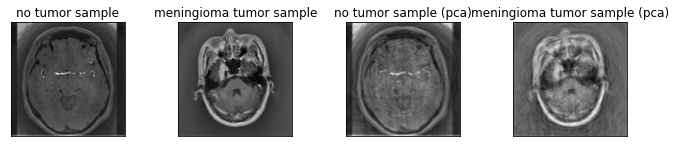

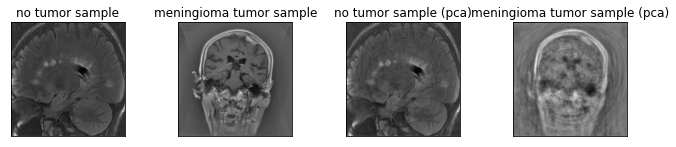

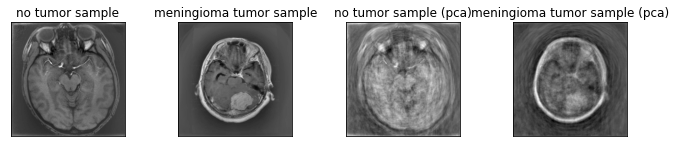

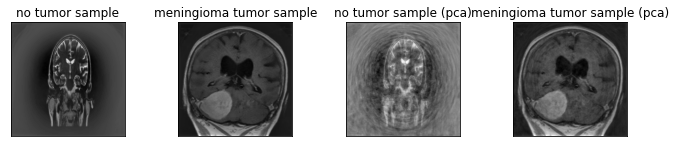

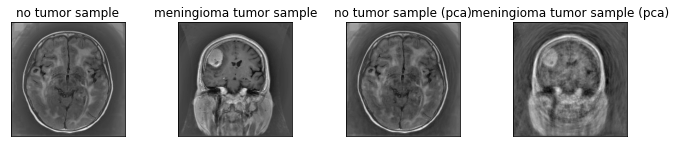

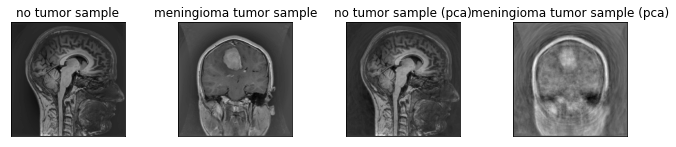

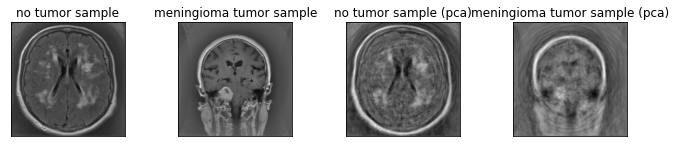

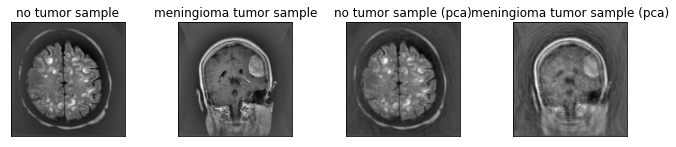

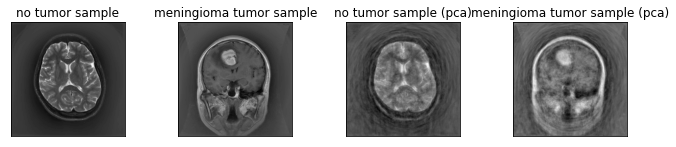

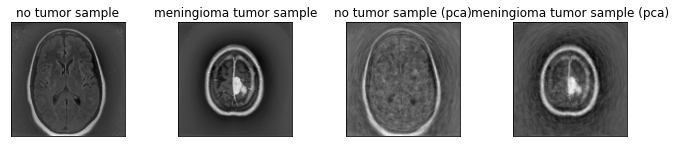

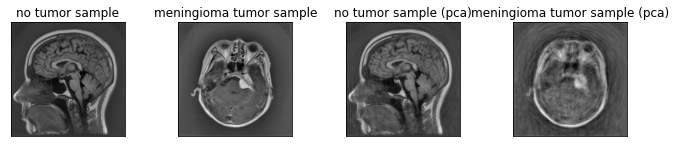

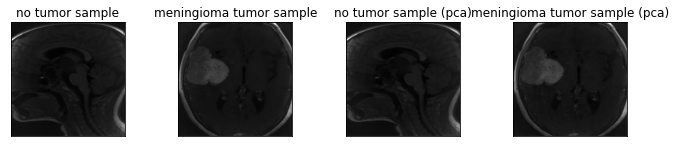

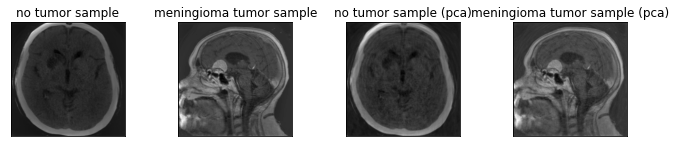

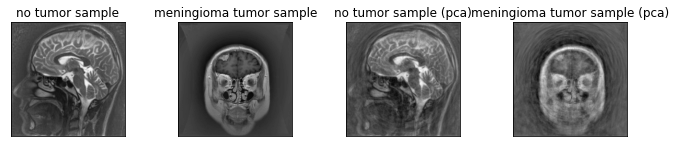

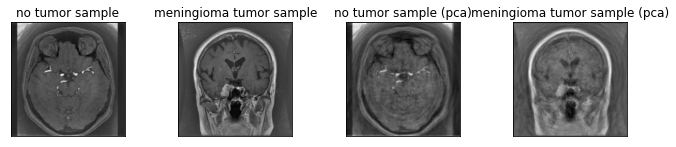

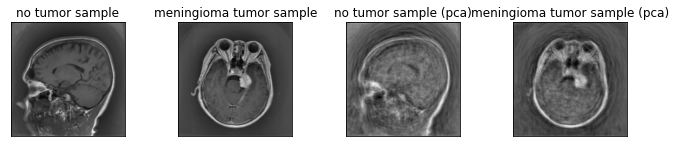

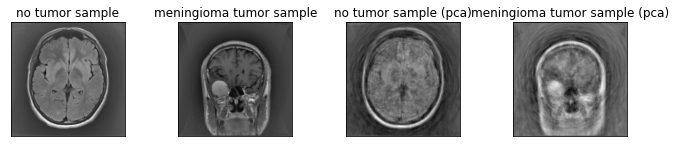

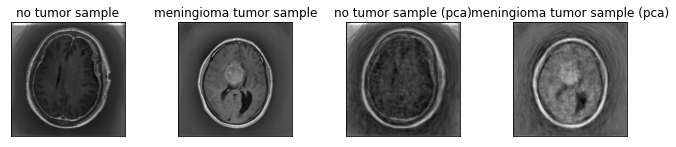

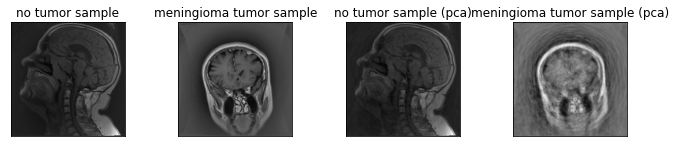

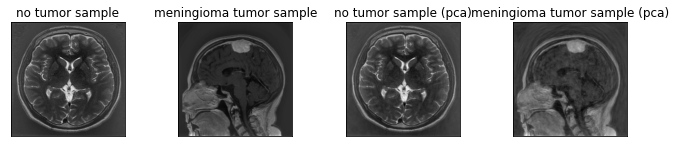

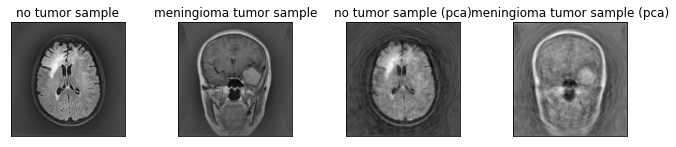

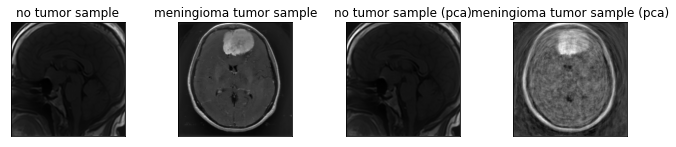

In [36]:
X_inv = pca.inverse_transform(pca_train)
for i in range(50):
    ind0 = np.where(y_train == 0)[0]
    rand0 = np.random.choice(ind0)
    ind3 = np.where(y_train == 3)[0]
    rand3 = np.random.choice(ind3)
    fig, ax = plt.subplots(1,4, figsize= (10,10))
    ax[0].imshow(X_train[rand0].reshape(255,255), cmap = 'gray')
    ax[0].set_title('no tumor sample')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    
    ax[1].imshow(X_train[rand3].reshape(255,255), cmap = 'gray')
    ax[1].set_title('meningioma tumor sample')
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    
    ax[2].imshow(X_inv[rand0].reshape(255,255), cmap = 'gray')
    ax[2].set_title('no tumor sample (pca)')
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    
    ax[3].imshow(X_inv[rand3].reshape(255,255), cmap = 'gray')
    ax[3].set_title('meningioma tumor sample (pca)')
    ax[3].set_xticks([])
    ax[3].set_yticks([])
    
    fig.tight_layout(pad=5.0)
    
    plt.show()
    


The class3/class0 confusion can seem to be justified by a little of blur added by the pca transform, which can hide actual tumors (it can also enhance tumor charactistics though) and that some tumors are initially poorly visible. Some MRIs are also dark, which can induce some difficulties classifying them (as tumors).